In [1]:
import torch
import numpy as np
from typing import List, Dict, Tuple, Optional
from transformers import PreTrainedModel, AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt


class SaliencyAnalyzer:
    """Analyzes information flow through saliency scores (Section 2.1)"""
    
    def __init__(self, model: PreTrainedModel):
        self.model = model
        
    def compute_saliency_scores(
        self, attention_matrices: List[torch.Tensor], loss: torch.Tensor
    ) -> List[torch.Tensor]:
        """
        Computes saliency scores using equation (1): Il = |∑h Ah,l ⊙ ∂L(x)/∂Ah,l|
        """
        # Enable gradient computation for attention matrices
        for A in attention_matrices:
            A.retain_grad()
            
        # Compute gradients
        loss.backward(retain_graph=True)
        
        # Calculate saliency scores
        saliency_scores = []
        for A in attention_matrices:
            grad = A.grad
            saliency = torch.abs(A * grad)  # Element-wise multiplication
            saliency_scores.append(saliency)
            
        return saliency_scores

    def compute_flow_metrics(
        self,
        saliency_scores: List[torch.Tensor],
        class_positions: torch.Tensor,
        target_position: int,
    ) -> Dict[str, List[float]]:
        """
        Computes text-to-label (Swp), label-to-target (Spq), and other (Sww) flow metrics
        using equations (2)-(4)
        """
        metrics = {"S_wp": [], "S_pq": [], "S_ww": []}
        
        for saliency in saliency_scores:
            # Text-to-label flow (Swp)
            wp_connections = self._get_text_to_label_connections(class_positions)
            S_wp = self._compute_average_flow(saliency, wp_connections)
            
            # Label-to-target flow (Spq)
            pq_connections = self._get_label_to_target_connections(class_positions, target_position)
            S_pq = self._compute_average_flow(saliency, pq_connections)
            
            # Other information flow (Sww)
            ww_connections = self._get_other_connections(
                class_positions, target_position, saliency.shape[-1]
            )
            S_ww = self._compute_average_flow(saliency, ww_connections)
            
            metrics["S_wp"].append(S_wp)
            metrics["S_pq"].append(S_pq)
            metrics["S_ww"].append(S_ww)
            
        return metrics

    def _get_text_to_label_connections(
        self, class_positions: torch.Tensor
    ) -> List[Tuple[int, int]]:
        """Gets connections from input text to label words."""
        return [(pos, j) for pos in class_positions.tolist() for j in range(pos)]

    def _get_label_to_target_connections(
        self, class_positions: torch.Tensor, target_position: int
    ) -> List[Tuple[int, int]]:
        """Gets connections from label words to target position."""
        return [(target_position, pos) for pos in class_positions.tolist()]

    def _get_other_connections(
        self, class_positions: torch.Tensor, target_position: int, seq_len: int
    ) -> List[Tuple[int, int]]:
        """Gets all other connections."""
        all_pairs = [(i, j) for i in range(seq_len) for j in range(i)]
        exclude = set(
            self._get_text_to_label_connections(class_positions)
            + self._get_label_to_target_connections(class_positions, target_position)
        )
        return list(set(all_pairs) - exclude)

    def _compute_average_flow(
        self, saliency: torch.Tensor, connections: List[Tuple[int, int]]
    ) -> float:
        """Computes average saliency for given connections."""
        if not connections:
            return 0.0
        total = sum(saliency[:, :, i, j].sum().item() for i, j in connections)
        return total / (len(connections) * saliency.shape[1])  # Normalize by num_heads


class InformationBlocker:
    """Implements information blocking for ablation studies (Section 2.2)"""

    def block_label_connections(
        self,
        attention_matrices: List[torch.Tensor],
        label_positions: List[int],
        layers_to_block: List[int],
    ) -> List[torch.Tensor]:
        """Blocks attention to/from label words in specified layers."""
        blocked_matrices = attention_matrices.copy()
        
        for layer_idx in layers_to_block:
            A = attention_matrices[layer_idx].clone()
            for pos in label_positions:
                # Block connections to label words
                A[:, :, pos, :pos] = 0
            blocked_matrices[layer_idx] = A
            
        return blocked_matrices

    def compute_loyalty_metrics(
        self, original_outputs: torch.Tensor, blocked_outputs: torch.Tensor
    ) -> Dict[str, float]:
        """Computes label and word loyalty metrics."""
        # Label loyalty
        orig_labels = original_outputs.argmax(dim=-1)
        block_labels = blocked_outputs.argmax(dim=-1)
        label_loyalty = (orig_labels == block_labels).float().mean().item()

        # Word loyalty (Jaccard similarity of top-5)
        orig_top5 = torch.topk(original_outputs, k=5, dim=-1).indices
        block_top5 = torch.topk(blocked_outputs, k=5, dim=-1).indices
        word_loyalty = self._compute_jaccard_similarity(orig_top5, block_top5)

        return {
            "label_loyalty": label_loyalty,
            "word_loyalty": word_loyalty
        }

    def _compute_jaccard_similarity(self, set1: torch.Tensor, set2: torch.Tensor) -> float:
        """Computes Jaccard similarity between token sets."""
        set1 = set(set1.flatten().tolist())
        set2 = set(set2.flatten().tolist())
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        return intersection / union if union > 0 else 0.0


class AttentionModeler:
    """Models and analyzes attention patterns (Section 2.3)"""

    def compute_attention_weights(
        self, query: torch.Tensor, key: torch.Tensor, dim: int
    ) -> torch.Tensor:
        """Computes scaled dot-product attention weights."""
        scores = torch.matmul(query, key.transpose(-2, -1))
        scores = scores / np.sqrt(dim)
        return torch.softmax(scores, dim=-1)

    def analyze_attention_patterns(
        self, attention_weights: torch.Tensor, labels: torch.Tensor
    ) -> Dict[str, torch.Tensor]:
        """Analyzes attention patterns using logistic regression."""
        x = attention_weights.view(attention_weights.size(0), -1)
        num_classes = labels.max().item() + 1
        
        # Simple linear model
        model = torch.nn.Linear(x.size(1), num_classes)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())
        
        # Train
        for _ in range(100):
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        return {
            "coefficients": model.weight.detach(),
            "num_classes": num_classes
        }
class AnchorReweighter:
    """Implements anchor re-weighting method (Section 3.1)"""
    
    def __init__(self, model: PreTrainedModel, num_layers: int, num_heads: int, num_classes: int):
        self.model = model
        # Initialize learnable weights for each layer, head, and class
        self.weights = torch.nn.Parameter(
            torch.zeros(num_layers, num_heads, num_classes)
        )
        self.optimizer = torch.optim.Adam([self.weights], lr=0.01)

    def forward(
        self,
        attention_matrices: List[torch.Tensor],
        label_positions: torch.Tensor,
        target_position: int,
    ) -> List[torch.Tensor]:
        """Applies learned weights to attention matrices."""
        weighted_matrices = []
        for l, A in enumerate(attention_matrices):
            A_new = A.clone()
            for h in range(A.size(1)):
                for i, pos in enumerate(label_positions):
                    # Apply weight using equation (9)
                    weight = torch.exp(self.weights[l, h, i])
                    A_new[:, h, target_position, pos] *= weight
            weighted_matrices.append(A_new)
        return weighted_matrices

    def train_step(
        self,
        batch: Dict[str, torch.Tensor],
        label_positions: torch.Tensor,
        target_position: int,
    ) -> float:
        """Performs one training step."""
        self.optimizer.zero_grad()
        
        # Forward pass with weighted attention
        outputs = self.model(
            **batch,
            output_attentions=True,
            return_dict=True
        )
        weighted_attention = self.forward(
            outputs.attentions,
            label_positions,
            target_position
        )
        
        # Compute loss
        logits = self.model.forward_with_attention(weighted_attention)
        loss = torch.nn.CrossEntropyLoss()(
            logits.view(-1, logits.size(-1)),
            batch["labels"].view(-1)
        )
        
        # Update weights
        loss.backward()
        self.optimizer.step()
        
        return loss.item()


class ContextCompressor:
    """Implements context compression technique (Section 3.2)"""
    
    def __init__(self, model: PreTrainedModel):
        self.model = model
        self.stored_states = {}

    def compress_demonstrations(
        self,
        demonstrations: List[Dict],
        label_positions: List[int]
    ) -> torch.Tensor:
        """Compresses demonstrations into anchor hidden states."""
        compressed_states = []
        
        for demo in demonstrations:
            # Get hidden states
            with torch.no_grad():
                outputs = self.model(
                    **demo,
                    output_hidden_states=True,
                    return_dict=True
                )
            
            # Extract states at label positions
            states = outputs.hidden_states[-1]  # Use final layer
            label_states = states[:, label_positions, :]
            compressed_states.append(label_states)
            
        return torch.cat(compressed_states, dim=1)

    def analyze_compression(
        self,
        original_outputs: torch.Tensor,
        compressed_outputs: torch.Tensor
    ) -> Dict[str, float]:
        """Analyzes compression quality."""
        mse = torch.mean((original_outputs - compressed_outputs) ** 2).item()
        cos_sim = torch.nn.functional.cosine_similarity(
            original_outputs.view(-1),
            compressed_outputs.view(-1),
            dim=0
        ).item()
        
        return {
            "mse": mse,
            "cosine_similarity": cos_sim
        }
        
class ICLVisualizer:
    """Visualization utilities for reproducing paper figures"""
    
    @staticmethod
    def plot_information_flow(
        layers: List[int],
        Swp: List[float],
        Spq: List[float],
        Sww: List[float],
        title: str = "",
        save_path: Optional[str] = None
    ):
        """Reproduces Figure 3: Information flow visualization."""
        plt.figure(figsize=(10, 6))
        plt.plot(layers, Swp, label='S_wp', color='blue')
        plt.plot(layers, Spq, label='S_pq', color='orange')
        plt.plot(layers, Sww, label='S_ww', color='green')
        
        plt.xlabel('Layer')
        plt.ylabel('S')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

    @staticmethod
    def plot_isolation_impact(
        metrics: Dict[str, List[float]],
        title: str = "",
        save_path: Optional[str] = None
    ):
        """Reproduces Figure 4: Impact of isolation experiments."""
        categories = [
            'Label Loyalty\n(GPT2-XL)',
            'Word Loyalty\n(GPT2-XL)',
            'Label Loyalty\n(GPT-J)',
            'Word Loyalty\n(GPT-J)'
        ]
        
        x = np.arange(len(categories))
        width = 0.15
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.bar(x - 2*width, metrics['no_isolation'], width, label='No Isolation')
        ax.bar(x - width, metrics['label_first'], width, label='Label Words (First)')
        ax.bar(x, metrics['label_last'], width, label='Label Words (Last)')
        ax.bar(x + width, metrics['random_first'], width, label='Random (First)')
        ax.bar(x + 2*width, metrics['random_last'], width, label='Random (Last)')
        
        ax.set_ylabel('Loyalty')
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(categories)
        ax.legend()
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()


# def run_experiments(dataset_name: str = "sst2"):
#     """Runs complete set of experiments from the paper"""
    
#     # Load models
#     model_xl = AutoModelForCausalLM.from_pretrained("gpt2-xl")
#     tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
    
#     # Initialize components
#     saliency_analyzer = SaliencyAnalyzer(model_xl)
#     info_blocker = InformationBlocker()
#     attention_modeler = AttentionModeler()
#     compressor = ContextCompressor(model_xl)
#     visualizer = ICLVisualizer()
    
#     # Load dataset
#     if dataset_name == "sst2":
#         # Example: SST-2 dataset
#         from datasets import load_dataset
#         dataset = load_dataset("glue", "sst2")
#         test_data = dataset["test"]

#         # Tokenize dataset
#         def tokenize(batch):
#             return tokenizer(batch["sentence"], padding="max_length", truncation=True, return_tensors="pt")
#         test_data = test_data.map(tokenize, batched=True)

#     # Placeholder for experiments: Add your specific inputs and targets
#     inputs = test_data["input_ids"]
#     targets = test_data["label"]

#     # Example: Compute Saliency Scores
#     outputs = model_xl(input_ids=inputs, labels=targets)
#     attention_matrices = outputs.attentions  # Extract attention matrices
#     loss = outputs.loss

#     # Compute saliency scores
#     saliency_scores = saliency_analyzer.compute_saliency_scores(attention_matrices, loss)

#     # Analyze information flow
#     class_positions = torch.tensor([5, 10])  # Example positions for label words
#     target_position = 15  # Example target position
#     flow_metrics = saliency_analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position)

#     # Visualization: Plot information flow metrics
#     visualizer.plot_information_flow(
#         layers=list(range(len(saliency_scores))),
#         Swp=flow_metrics["S_wp"],
#         Spq=flow_metrics["S_pq"],
#         Sww=flow_metrics["S_ww"],
#         title="Information Flow Metrics",
#         save_path="info_flow_metrics.png"
#     )

#     # Example: Perform information blocking
#     label_positions = [5, 10]  # Example label word positions
#     layers_to_block = [0, 1, 2]  # Block in the first 3 layers
#     blocked_attention = info_blocker.block_label_connections(attention_matrices, label_positions, layers_to_block)

#     # Compute loyalty metrics
#     blocked_outputs = model_xl(input_ids=inputs, labels=targets, attention_mask=blocked_attention)
#     loyalty_metrics = info_blocker.compute_loyalty_metrics(outputs.logits, blocked_outputs.logits)

#     print("Loyalty Metrics:", loyalty_metrics)

#     # Context compression example
#     compressed_states = compressor.compress_demonstrations(test_data, label_positions)
#     compressed_outputs = model_xl(inputs_embeds=compressed_states)
#     compression_metrics = compressor.analyze_compression(outputs.logits, compressed_outputs.logits)

#     print("Compression Metrics:", compression_metrics)

#     # Anchor re-weighting example
#     reweighter = AnchorReweighter(model_xl, num_layers=48, num_heads=16, num_classes=2)
#     loss_value = reweighter.train_step(
#         batch={"input_ids": inputs, "labels": targets},
#         label_positions=torch.tensor(label_positions),
#         target_position=target_position
#     )

#     print("Anchor Re-weighting Loss:", loss_value)
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from datasets import load_dataset

def run_experiments(dataset_name: str = "sst2"):
    """Runs complete set of experiments for GPT-2"""
    
    # Load GPT-2 model and tokenizer
    model = AutoModelForCausalLM.from_pretrained("gpt2")
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token 
    
    # Initialize components
    saliency_analyzer = SaliencyAnalyzer(model)
    info_blocker = InformationBlocker()
    attention_modeler = AttentionModeler()
    compressor = ContextCompressor(model)
    visualizer = ICLVisualizer()
    
    # Load dataset
    if dataset_name == "sst2":
        # Example: SST-2 dataset
        dataset = load_dataset("glue", "sst2")
        test_data = dataset["test"]

        # Tokenize dataset
        def tokenize(batch):
            tokenized = tokenizer(batch["sentence"], padding="max_length", truncation=True)
            # Convert tokenized data to PyTorch tensors
            return {k: torch.tensor(v) for k, v in tokenized.items()}
        
        test_data = test_data.map(tokenize, batched=True)

    # Placeholder for experiments: Add your specific inputs and targets
    # inputs = torch.stack([example["input_ids"] for example in test_data])  # Access input_ids
    # targets = torch.tensor([example["label"] for example in test_data]) 
    inputs = torch.tensor(test_data["input_ids"])  # Directly access all input_ids as a tensor
    targets = torch.tensor(test_data["label"])    # Directly access all labels as a tensor


    # Example: Compute Saliency Scores
    outputs = model(input_ids=inputs, labels=targets)
    attention_matrices = outputs.attentions  # Extract attention matrices
    loss = outputs.loss

    # Compute saliency scores
    saliency_scores = saliency_analyzer.compute_saliency_scores(attention_matrices, loss)

    # Analyze information flow
    class_positions = torch.tensor([5, 10])  # Example positions for label words
    target_position = 15  # Example target position
    flow_metrics = saliency_analyzer.compute_flow_metrics(saliency_scores, class_positions, target_position)

    # Visualization: Plot information flow metrics
    visualizer.plot_information_flow(
        layers=list(range(len(saliency_scores))),
        Swp=flow_metrics["S_wp"],
        Spq=flow_metrics["S_pq"],
        Sww=flow_metrics["S_ww"],
        title="Information Flow Metrics",
        save_path="info_flow_metrics.png"
    )

    # Example: Perform information blocking
    label_positions = [5, 10]  # Example label word positions
    layers_to_block = [0, 1, 2]  # Block in the first 3 layers
    blocked_attention = info_blocker.block_label_connections(attention_matrices, label_positions, layers_to_block)

    # Compute loyalty metrics
    blocked_outputs = model(input_ids=inputs, labels=targets, attention_mask=blocked_attention)
    loyalty_metrics = info_blocker.compute_loyalty_metrics(outputs.logits, blocked_outputs.logits)

    print("Loyalty Metrics:", loyalty_metrics)

    # Context compression example
    compressed_states = compressor.compress_demonstrations(test_data, label_positions)
    compressed_outputs = model(inputs_embeds=compressed_states)
    compression_metrics = compressor.analyze_compression(outputs.logits, compressed_outputs.logits)

    print("Compression Metrics:", compression_metrics)

    # Anchor re-weighting example
    reweighter = AnchorReweighter(model, num_layers=12, num_heads=12, num_classes=2)
    loss_value = reweighter.train_step(
        batch={"input_ids": inputs, "labels": targets},
        label_positions=torch.tensor(label_positions),
        target_position=target_position
    )

    print("Anchor Re-weighting Loss:", loss_value)

run_experiments(dataset_name="sst2")

/opt/anaconda3/envs/marketpulse/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def run_experiments(dataset_name: str = "sst2"):
    """Runs complete set of experiments for GPT-2"""

    # Load GPT-2 model and tokenizer
    model = AutoModelForCausalLM.from_pretrained("gpt2")
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Load dataset
    if dataset_name == "sst2":
        dataset = load_dataset("glue", "sst2")
        test_data = dataset["test"]

        # Tokenize dataset
        def tokenize(batch):
            tokenized = tokenizer(batch["sentence"], padding="max_length", truncation=True)
            return tokenized

        # Apply tokenization
        test_data = test_data.map(tokenize, batched=True)

    # Convert input_ids and labels to PyTorch tensors
    input_ids = torch.tensor(np.stack(test_data["input_ids"]))  # Convert list of lists to tensor
    labels = torch.tensor(test_data["label"])  # Directly convert labels to tensor

    # Example: Compute Saliency Scores
    outputs = model(input_ids=input_ids, labels=labels)
    attention_matrices = outputs.attentions  # Extract attention matrices
    loss = outputs.loss

    print(f"Loss: {loss.item()}")
run_experiments(dataset_name="sst2")

Map: 100%|██████████| 1821/1821 [00:01<00:00, 1554.04 examples/s]


In [12]:
print(test_data[0])

NameError: name 'test_data' is not defined

/opt/anaconda3/envs/marketpulse/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Prefix Matching Heads: [(0, 1), (0, 5), (0, 10), (1, 11), (3, 0), (4, 7), (11, 0), (11, 3), (11, 8)]
Copying Scores: {(0, 0): 0.024325678769785624, (0, 1): 0.20252604897205645, (0, 2): 0.024347236236700646, (0, 3): 0.0045866724820091175, (0, 4): 0.034269616867487245, (0, 5): 0.19753917593222398, (0, 6): 0.023910010806643046, (0, 7): 0.006975282126894364, (0, 8): 0.0666858175626168, (0, 9): 0.029629460894144498, (0, 10): 0.0916287016410094, (0, 11): 0.04100355219382506, (1, 0): 0.005632983878828012, (1, 1): 0.009212431999353262, (1, 2): 0.021369302358764868, (1, 3): 0.016783942110263385, (1, 4): 0.020879766402336266, (1, 5): 0.04011277238336893, (1, 6): 0.044966378034307405, (1, 7): 0.015902659211021204, (1, 8): 0.02387135038868739, (1, 9): 0.017916402421318568, (1, 10): 0.03361872640939859, (1, 11): 0.13895013355291808, (2, 0): 0.005499902503708234, (2, 1): 0.018694133426134404, (2, 2): 7.83065541047388e-05, (2, 3): 0.0014386154048574658, (2, 4): 0.002240093281635871, (2, 5): 0.0014395

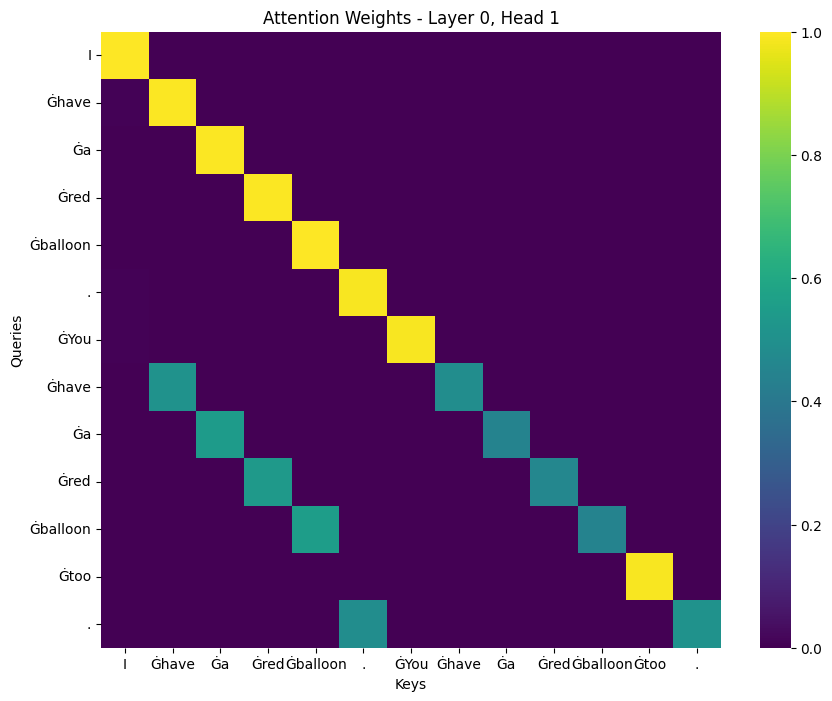

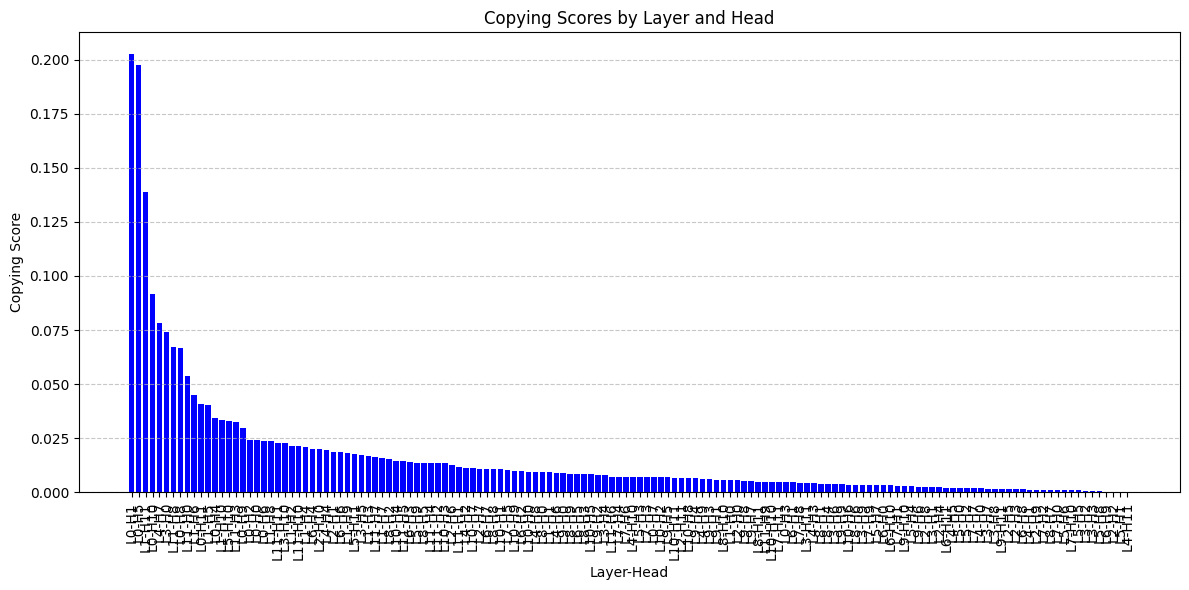

In [6]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

class InductionHeadAnalyzer:
    def __init__(self, model_name="gpt2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

    def get_attention_weights(self, input_text):
        """Tokenize input text and extract attention weights."""
        tokens = self.tokenizer(input_text, return_tensors="pt")
        outputs = self.model(**tokens)
        return tokens, outputs.attentions

    def find_induction_heads(self, tokens, attentions):
        """Identify heads performing prefix matching and copying."""
        prefix_match_heads = []
        for layer_idx, layer_attentions in enumerate(attentions):
            for head_idx, head_attention in enumerate(layer_attentions[0]):  # Batch size = 1
                if self._is_prefix_matching(tokens, head_attention):
                    prefix_match_heads.append((layer_idx, head_idx))
        return prefix_match_heads

    def _is_prefix_matching(self, tokens, head_attention):
        """Check if an attention head performs prefix matching."""
        token_indices = tokens["input_ids"][0].tolist()
        for i, token in enumerate(token_indices):
            if token in token_indices[:i] and head_attention[i].argmax().item() == token_indices[:i].index(token):
                return True
        return False

    def compute_copying_scores(self, tokens, attentions):
        """Compute how much heads boost the probability of copied tokens."""
        copying_scores = {}
        for layer_idx, layer_attentions in enumerate(attentions):
            for head_idx, head_attention in enumerate(layer_attentions[0]):
                score = self._compute_head_copying_score(tokens, head_attention)
                if score > 0:
                    copying_scores[(layer_idx, head_idx)] = score
        return copying_scores

    def _compute_head_copying_score(self, tokens, head_attention):
        """Calculate copying score for a given attention head."""
        token_indices = tokens["input_ids"][0].tolist()
        score = 0
        for i, token in enumerate(token_indices):
            if token in token_indices[:i]:
                attention_on_previous = head_attention[i, token_indices[:i].index(token)].item()
                score += attention_on_previous
        return score / len(token_indices)

    def visualize_attention(self, tokens, attentions, layer_idx, head_idx):
        """Visualize attention weights for a specific head."""
        token_strings = self.tokenizer.convert_ids_to_tokens(tokens["input_ids"][0].tolist())
        attention_matrix = attentions[layer_idx][0, head_idx].detach().cpu().numpy()

        plt.figure(figsize=(10, 8))
        sns.heatmap(attention_matrix, xticklabels=token_strings, yticklabels=token_strings, cmap="viridis", annot=False)
        plt.title(f"Attention Weights - Layer {layer_idx}, Head {head_idx}")
        plt.xlabel("Keys")
        plt.ylabel("Queries")
        plt.show()

    def plot_copying_scores(self, copying_scores):
        """Bar chart of copying scores for all heads."""
        sorted_scores = sorted(copying_scores.items(), key=lambda x: x[1], reverse=True)

        # Extract labels and scores
        labels = [f"L{layer}-H{head}" for (layer, head), _ in sorted_scores]
        scores = [score for _, score in sorted_scores]

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.bar(labels, scores, color='blue')
        plt.xlabel('Layer-Head')
        plt.ylabel('Copying Score')
        plt.title('Copying Scores by Layer and Head')
        plt.xticks(rotation=90)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Example Usage
if __name__ == "__main__":
    text = "I have a red balloon. You have a red balloon too."
    analyzer = InductionHeadAnalyzer(model_name="gpt2")
    tokens, attentions = analyzer.get_attention_weights(text)

    # Find induction heads
    prefix_heads = analyzer.find_induction_heads(tokens, attentions)
    print(f"Prefix Matching Heads: {prefix_heads}")

    # Compute copying scores
    copying_scores = analyzer.compute_copying_scores(tokens, attentions)
    print(f"Copying Scores: {copying_scores}")

    # Visualize attention weights for a specific head
    if prefix_heads:
        layer, head = prefix_heads[0]
        analyzer.visualize_attention(tokens, attentions, layer_idx=layer, head_idx=head)

    # Plot copying scores
    analyzer.plot_copying_scores(copying_scores)


In [3]:
!pip install seaborn

In [7]:
"""
In-Context Learning Analysis Framework
Implements analysis methods from 'Identifying Semantic Induction Heads to Understand In-Context Learning'
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import List, Dict, Tuple, Union, Optional
from dataclasses import dataclass
import pandas as pd
from tqdm import tqdm
import json
import logging
from pathlib import Path

@dataclass
class ICLTestCase:
    """Structure for ICL test cases"""
    prompt: str
    examples: List[Dict[str, str]]
    query: str
    expected_format: str
    correct_answer: str
    task_type: str

@dataclass
class ICLResult:
    """Structure for ICL analysis results"""
    loss_reduction: float
    format_compliance: float
    pattern_discovery: float
    num_shots: int
    checkpoint: str

class ICLAnalyzer:
    """Main class for analyzing in-context learning capabilities"""
    
    def __init__(
        self,
        model_name: str,
        cache_dir: Optional[str] = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.model_name = model_name
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            cache_dir=cache_dir,
            output_attentions=True,
            output_hidden_states=True
        ).to(device)
        
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def analyze_loss_reduction(
        self,
        text: str,
        early_tokens: int = 50,
        late_tokens: int = 50
    ) -> float:
        """
        Analyze loss reduction between early and late tokens.
        
        Args:
            text: Input text to analyze
            early_tokens: Number of early tokens to consider
            late_tokens: Number of late tokens to consider
            
        Returns:
            Difference between late and early token loss
        """
        tokens = self.tokenizer(text, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**tokens, labels=tokens["input_ids"])
            
        # Get loss per token
        loss = outputs.loss.cpu().numpy()
        
        # Calculate average loss for early and late tokens
        early_loss = np.mean(loss[:early_tokens])
        late_loss = np.mean(loss[-late_tokens:])
        
        return late_loss - early_loss

    def check_format_compliance(
        self,
        generated: str,
        expected_format: str
    ) -> bool:
        """
        Check if generated text complies with expected format.
        
        Args:
            generated: Generated text
            expected_format: Expected format (e.g., "number", "true_false", "classification")
            
        Returns:
            Boolean indicating format compliance
        """
        if expected_format == "number":
            return generated.strip().isdigit()
        elif expected_format == "true_false":
            return generated.strip().lower() in ["true", "false"]
        elif expected_format == "classification":
            return generated.strip() in ["0", "1", "2", "3"]
        return False

    def analyze_pattern_discovery(
        self,
        test_case: ICLTestCase,
        n_shots: int
    ) -> float:
        """
        Analyze pattern discovery ability.
        
        Args:
            test_case: Test case containing examples and query
            n_shots: Number of examples to include
            
        Returns:
            Accuracy score for pattern discovery
        """
        # Construct prompt with n_shots examples
        prompt = self.construct_prompt(test_case, n_shots)
        
        # Generate response
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
        
        generated = self.tokenizer.decode(outputs[0][-1])
        
        # Check if generated answer matches correct answer
        return float(generated.strip() == test_case.correct_answer)

    def construct_prompt(
        self,
        test_case: ICLTestCase,
        n_shots: int
    ) -> str:
        """
        Construct few-shot prompt from test case.
        
        Args:
            test_case: Test case containing examples
            n_shots: Number of examples to include
            
        Returns:
            Constructed prompt string
        """
        prompt = ""
        for i in range(min(n_shots, len(test_case.examples))):
            example = test_case.examples[i]
            prompt += f"Example {i+1}:\n{example['input']}\nAnswer: {example['output']}\n\n"
        
        prompt += f"Query:\n{test_case.query}\nAnswer:"
        return prompt

    def run_complete_analysis(
        self,
        test_cases: List[ICLTestCase],
        n_shots_list: List[int] = [0, 1, 2, 5, 10, 20],
        checkpoints: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """
        Run complete ICL analysis across test cases and shots.
        
        Args:
            test_cases: List of test cases
            n_shots_list: List of shot numbers to test
            checkpoints: Optional list of model checkpoints
            
        Returns:
            DataFrame with analysis results
        """
        results = []
        
        # If no checkpoints provided, just use current model
        if not checkpoints:
            checkpoints = [self.model_name]
            
        for checkpoint in tqdm(checkpoints, desc="Analyzing checkpoints"):
            if checkpoint != self.model_name:
                self.model = AutoModelForCausalLM.from_pretrained(
                    checkpoint,
                    output_attentions=True,
                    output_hidden_states=True
                ).to(self.device)
                
            for n_shots in tqdm(n_shots_list, desc="Testing shot numbers"):
                for test_case in test_cases:
                    # Analyze loss reduction
                    loss_red = self.analyze_loss_reduction(test_case.prompt)
                    
                    # Test format compliance
                    format_comp = self.check_format_compliance(
                        self.generate_completion(test_case, n_shots),
                        test_case.expected_format
                    )
                    
                    # Test pattern discovery
                    pattern_disc = self.analyze_pattern_discovery(test_case, n_shots)
                    
                    results.append(ICLResult(
                        loss_reduction=loss_red,
                        format_compliance=float(format_comp),
                        pattern_discovery=pattern_disc,
                        num_shots=n_shots,
                        checkpoint=checkpoint
                    ))
                    
        return pd.DataFrame([vars(r) for r in results])

    def generate_completion(
        self,
        test_case: ICLTestCase,
        n_shots: int
    ) -> str:
        """Generate completion for a test case."""
        prompt = self.construct_prompt(test_case, n_shots)
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=1,
                pad_token_id=self.tokenizer.eos_token_id
            )
            
        return self.tokenizer.decode(outputs[0][-1])

    def visualize_results(
        self,
        results: pd.DataFrame,
        save_path: Optional[str] = None
    ) -> None:
        """
        Visualize ICL analysis results.
        
        Args:
            results: DataFrame with analysis results
            save_path: Optional path to save visualization
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        metrics = ['loss_reduction', 'format_compliance', 'pattern_discovery']
        titles = ['Loss Reduction', 'Format Compliance', 'Pattern Discovery']
        
        for ax, metric, title in zip(axes, metrics, titles):
            sns.lineplot(
                data=results,
                x='num_shots',
                y=metric,
                hue='checkpoint',
                marker='o',
                ax=ax
            )
            ax.set_title(title)
            ax.set_xlabel('Number of Shots')
            ax.set_ylabel('Score')
            
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

class TestCaseGenerator:
    """Helper class to generate ICL test cases"""
    
    @staticmethod
    def generate_classification_test(
        num_classes: int,
        num_examples: int
    ) -> ICLTestCase:
        """Generate classification test case."""
        examples = []
        for i in range(num_examples):
            label = str(np.random.randint(num_classes))
            examples.append({
                "input": f"Example {i+1}",
                "output": label
            })
            
        return ICLTestCase(
            prompt="Classification task",
            examples=examples,
            query="Final example",
            expected_format="classification",
            correct_answer="0",  # Will be randomly selected during testing
            task_type="classification"
        )

    @staticmethod
    def generate_relation_test() -> ICLTestCase:
        """Generate relation justification test case."""
        examples = [
            {"input": "cat, animal", "output": "true"},
            {"input": "tree, building", "output": "false"}
        ]
        
        return ICLTestCase(
            prompt="Relation justification task",
            examples=examples,
            query="dog, animal",
            expected_format="true_false",
            correct_answer="true",
            task_type="relation"
        )

def main():
    """Example usage of the framework."""
    # Initialize analyzer
    analyzer = ICLAnalyzer("gpt2")
    
    # Generate test cases
    test_cases = [
        TestCaseGenerator.generate_classification_test(2, 10),
        TestCaseGenerator.generate_classification_test(4, 10),
        TestCaseGenerator.generate_relation_test()
    ]
    
    # Run analysis
    results = analyzer.run_complete_analysis(
        test_cases,
        n_shots_list=[0, 1, 2, 5, 10]
    )
    
    # Visualize results
    analyzer.visualize_results(results, "icl_analysis.png")
    
    # Save results
    results.to_csv("icl_analysis_results.csv")

if __name__ == "__main__":
    main()

/opt/anaconda3/envs/marketpulse/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/opt/anaconda3/envs/marketpulse/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Analyzing checkpoints:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [8]:
class PaperAlignedTests:
    """
    Test cases exactly matching those from the paper (Section 4.1 and Table 1)
    """
    @staticmethod
    def binary_classification_tests() -> List[ICLTestCase]:
        """
        Binary classification tests from paper:
        1. (fruit, month) pair -> 0/1
        2. (furniture, profession) pair -> 0/1
        
        Format: "<E1, E2>: 0; <E2, E1>: 1"
        """
        # Test case 1: fruit-month
        fruit_month = ICLTestCase(
            prompt="Classify pairs of items. Format: <item1, item2>: label\n",
            examples=[
                {"input": "<apple, January>: 0", "output": "0"},
                {"input": "<March, banana>: 1", "output": "1"},
                {"input": "<orange, April>: 0", "output": "0"},
            ],
            query="<grape, May>:",
            expected_format="number",
            correct_answer="0",
            task_type="binary_classification"
        )

        # Test case 2: furniture-profession
        furniture_profession = ICLTestCase(
            prompt="Classify pairs of items. Format: <item1, item2>: label\n",
            examples=[
                {"input": "<chair, doctor>: 0", "output": "0"},
                {"input": "<lawyer, table>: 1", "output": "1"},
                {"input": "<desk, teacher>: 0", "output": "0"},
            ],
            query="<nurse, sofa>:",
            expected_format="number",
            correct_answer="1",
            task_type="binary_classification"
        )

        return [fruit_month, furniture_profession]

    @staticmethod
    def four_class_classification_test() -> ICLTestCase:
        """
        Four-class classification from paper using (fruit, month):
        <E1, E1>: 0; <E1, E2>: 1; <E2, E1>: 2; <E2, E2>: 3
        """
        return ICLTestCase(
            prompt="Classify pairs into four classes. Format: <item1, item2>: class\n",
            examples=[
                {"input": "<apple, apple>: 0", "output": "0"},
                {"input": "<banana, March>: 1", "output": "1"},
                {"input": "<April, orange>: 2", "output": "2"},
                {"input": "<May, June>: 3", "output": "3"},
            ],
            query="<grape, July>:",
            expected_format="classification",
            correct_answer="1",  # since first item is fruit, second is month
            task_type="four_class"
        )

    @staticmethod
    def nine_class_classification_test() -> ICLTestCase:
        """
        Nine-class classification from paper using (fruit, animal, month):
        <E1, E1>: 0; <E1, E2>: 1; <E1, E3>: 2; <E2, E1>: 3; ...
        """
        return ICLTestCase(
            prompt="Classify pairs into nine classes. Format: <item1, item2>: class\n",
            examples=[
                {"input": "<apple, apple>: 0", "output": "0"},
                {"input": "<banana, dog>: 1", "output": "1"},
                {"input": "<orange, March>: 2", "output": "2"},
                {"input": "<cat, grape>: 3", "output": "3"},
                {"input": "<dog, cat>: 4", "output": "4"},
                {"input": "<bird, April>: 5", "output": "5"},
                {"input": "<May, apple>: 6", "output": "6"},
                {"input": "<June, cat>: 7", "output": "7"},
                {"input": "<July, August>: 8", "output": "8"},
            ],
            query="<pear, elephant>:",
            expected_format="classification",
            correct_answer="1",  # since first is fruit, second is animal
            task_type="nine_class"
        )

    @staticmethod
    def relation_justification_tests() -> List[ICLTestCase]:
        """
        Relation justification tests from paper:
        - (subj, verb)
        - (verb, obj)
        - (mod, obj)
        - (part, whole)
        Format: "<E1, E2>: true; <animal, month>: false"
        """
        test_cases = []
        
        # Subject-Predicate relation
        subj_verb = ICLTestCase(
            prompt="Determine if the subject-verb relationship is valid. Answer true or false.\n",
            examples=[
                {"input": "<dog, bark>: true", "output": "true"},
                {"input": "<chair, run>: false", "output": "false"},
            ],
            query="<bird, fly>:",
            expected_format="true_false",
            correct_answer="true",
            task_type="relation_subj_verb"
        )
        
        # Verb-Object relation
        verb_obj = ICLTestCase(
            prompt="Determine if the verb-object relationship is valid. Answer true or false.\n",
            examples=[
                {"input": "<eat, apple>: true", "output": "true"},
                {"input": "<sleep, mountain>: false", "output": "false"},
            ],
            query="<drink, water>:",
            expected_format="true_false",
            correct_answer="true",
            task_type="relation_verb_obj"
        )
        
        # Modifier-Object relation
        mod_obj = ICLTestCase(
            prompt="Determine if the modifier-object relationship is valid. Answer true or false.\n",
            examples=[
                {"input": "<red, apple>: true", "output": "true"},
                {"input": "<tall, happiness>: false", "output": "false"},
            ],
            query="<blue, sky>:",
            expected_format="true_false",
            correct_answer="true",
            task_type="relation_mod_obj"
        )
        
        # Part-Whole relation
        part_whole = ICLTestCase(
            prompt="Determine if the part-whole relationship is valid. Answer true or false.\n",
            examples=[
                {"input": "<wheel, car>: true", "output": "true"},
                {"input": "<leaf, rock>: false", "output": "false"},
            ],
            query="<engine, car>:",
            expected_format="true_false",
            correct_answer="true",
            task_type="relation_part_whole"
        )

        return [subj_verb, verb_obj, mod_obj, part_whole]

def main():
    """Example usage with paper-aligned test cases"""
    analyzer = ICLAnalyzer("gpt2")
    
    # Get all test cases from paper
    test_cases = (
        PaperAlignedTests.binary_classification_tests() +
        [PaperAlignedTests.four_class_classification_test()] +
        [PaperAlignedTests.nine_class_classification_test()] +
        PaperAlignedTests.relation_justification_tests()
    )
    
    # Run analysis with shot numbers from paper
    results = analyzer.run_complete_analysis(
        test_cases,
        n_shots_list=[0, 1, 2, 3, 4, 5, 10, 20]  # Shot numbers used in paper
    )
    
    analyzer.visualize_results(results)

if __name__ == "__main__":
    main()

Analyzing checkpoints:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [2]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# Load model and tokenizer (replace with an open-source LLM)
model_name = "internlm/1.8b"  # Replace with a compatible model
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load AGENDA dataset or similar
dataset = load_dataset("AGENDA")
train_data = dataset['train']
test_data = dataset['test']



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.12/site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import